# ------------------------------------------------------------------------------
# This script was originally provided by Yilun Guan as a Colab notebook titled
# "TOD_simulator_v2.ipynb" and has been adapted for use in this project.
#
# All simulation helper functions and structures in other files (e.g.,
# simulatedDataGenerationHelper.py) are derived or built upon this notebook.
# ------------------------------------------------------------------------------


## Prerequisite

In [ ]:
# !pip install shapely alphashape so3g pixell
# !pip install git+https://github.com/guanyilun/moby2_light.git@yg/dev

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.1/541.1 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 712.0/712.0 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 9.1 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=c1bfb752e7dd09242ff6451f36815dd3ed029e4067c6a0e29f84f1949fc2b586
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481

In [ ]:
import numpy as np
from numpy.typing import NDArray
from typing import Protocol, Optional, Tuple, Any
from dataclasses import dataclass
from matplotlib import pyplot as plt
import alphashape
from shapely.geometry import Point, Polygon
from so3g.proj import coords, quat
from pixell import enmap
from moby2.tod.cuts import CutsVector


In [ ]:
# useful units
deg = np.deg2rad(1)
arcmin = deg / 60
s = 1 # second
Hz = 1/s

In [ ]:
@dataclass
class FocalPlane:
    x: np.ndarray  # in radian
    y: np.ndarray  # in radian

    @classmethod
    def from_radius(cls, radius: float = 0.5*deg, nrows: int = 30):
        """
        Generates a circular focal plane with a given radius and number of rows.

        The focal plane is represented as a set of x and y coordinates
        in radians, arranged in a circular pattern.
        The radius is the distance from the center to the edge of the circle.

        Args:
            radius (float): The radius of the circular focal plane in radians.
            nrows (int): The number of rows to generate. This determines the
                         density of detectors in the focal plane.
        Returns:
            FocalPlane: A new instance of the FocalPlane class with x and y
                        coordinates of the detectors.

        """
        X, Y = np.meshgrid(np.linspace(-1,1, nrows), np.linspace(-1, 1, nrows))
        m = (X**2 + Y**2) < 1
        return cls(X[m]*radius, Y[m]*radius)

    def get_circular_cover(self, n_dummy: int = 50) -> "FocalPlane":
        """
        Generates a circular arrangement of dummy detectors that encloses
        the existing detectors in the focal plane.

        The circle is centered at the mean position of the existing detectors.
        Its radius is determined by the maximum distance from this center
        to any existing detector.

        Args:
            n_dummy (int): The number of dummy detectors for the circular cover.

        Returns:
            FocalPlane: A new FocalPlane instance with the coordinates
                        of the dummy detectors.
        """
        if self.x.size == 0:
            # No detectors to cover, so return an empty cover.
            return FocalPlane(np.array([]), np.array([]))

        # Calculate the mean position (center) of the existing detectors.
        center_x = np.mean(self.x)
        center_y = np.mean(self.y)

        # Calculate the distances of each detector from this calculated center.
        relative_x = self.x - center_x
        relative_y = self.y - center_y
        distances_from_center = np.sqrt(relative_x**2 + relative_y**2)

        # The radius of the cover is the maximum of these distances.
        # If there's only one point, this radius will be 0.
        cover_radius = np.max(distances_from_center) if distances_from_center.size > 0 else 0.0

        # Generate angles for the dummy detectors, evenly spaced.
        angles = np.linspace(0, 2 * np.pi, n_dummy, endpoint=False)

        # Calculate coordinates of dummy detectors on the circle around
        # the calculated center.
        dummy_x = center_x + cover_radius * np.cos(angles)
        dummy_y = center_y + cover_radius * np.sin(angles)

        return FocalPlane(dummy_x, dummy_y)

    @property
    def n_dets(self):
        return len(self.x)

In [ ]:
@dataclass
class Scan:
    t: NDArray   # time vector in seconds. shape: (nsamps,)
    az: NDArray  # azimuth vector in radians. shape: (nsamps,)
    el: NDArray  # elevation vector in radians. shape: (nsamps,)
    srate: float

    def get_q_bore(self):
        q_bore = coords.CelestialSightLine.az_el(self.t, self.az, self.el, weather='typical').Q
        return q_bore

    @property
    def nsamps(self):
        return len(self.t)


def generate_ces_scan(
    t0: float,
    az: float,                 # Starting azimuth of the scan range in radians
    el: float,                 # Constant elevation for the scan in radians
    az_throw: float,           # Width of the azimuth scan in radians
    v_az: float = 1 * deg / s, # Azimuth scanning speed in radians per second. Default: 1 deg/s.
    srate: float = 200 * Hz,   # Sample interval in seconds (1 / sample_rate_hz). Default: 0.0025s.
    duration: float = 300.0    # Total duration for the scan in seconds. Default: 10 * 60s.
) -> Scan:
    """
    Generates a Constant Elevation Scan (CES) pattern.

    The scan sweeps back and forth in azimuth at a constant elevation.
    The phase of the scan is continuous with respect to t0.

    Args:
        t0: Absolute start time of the first sample in the returned time vector
            (in seconds, e.g., a Unix timestamp).
        az: The minimum azimuth of the scan range (in radians). This is the
            starting edge of the az_throw.
        el: The constant elevation for the scan (in radians).
        az_throw: The width of the azimuth scan (in radians). The scan will be
                  between 'az' and 'az + az_throw'. Must be non-negative.
        v_az: The scanning speed in azimuth (in radians per second).
              Must be positive if az_throw > 0.
        srate: The time interval between consecutive samples (in Hz).
        duration: The total duration for which to generate the scan pattern
                  (in seconds). Must be positive.

    Returns:
        Scan
    """
    # Input validation
    if az_throw < 0:
        raise ValueError("Azimuth throw (az_throw) must be non-negative.")
    if srate <= 0:
        raise ValueError("Sample interval (srate) must be positive.")
    if duration <= 0:
        # Return empty arrays for non-positive duration, or if no samples generated
        return Scan(np.array([]), np.array([]), np.array([]), srate=0)
    if az_throw > 0 and v_az <= 0:
        raise ValueError("Azimuth speed (v_az) must be positive if az_throw is positive.")

    t_vector = np.arange(0, duration, 1/srate) + t0
    if t_vector.size == 0:
        return Scan(np.array([]), np.array([]), np.array([]))

    # Azimuth scan parameters
    az_min_rad = az
    az_max_rad = az + az_throw

    # Handle staring scan (az_throw is 0)
    if az_throw == 0:
        az_vector = np.full_like(t_vector, az_min_rad)
        el_vector = np.full_like(t_vector, el)
        return Scan(t=t_vector, az=az_vector, el=el_vector, srate=0)

    # Time for a single sweep (e.g., from az_min_rad to az_max_rad)
    time_per_sweep = az_throw / v_az

    # Calculate azimuth: every two sweeps give one cycle
    phase = (t_vector / time_per_sweep) % 2.0
    mask = phase > 1.0
    phase[mask] = 2.0 - phase[mask]
    az_vector = az_min_rad * (1.0 - phase) + az_max_rad * phase

    # Elevation is constant
    el_vector = np.full_like(t_vector, el)

    return Scan(t=t_vector, az=az_vector, el=el_vector, srate=srate)


@dataclass
class TOD:
    scan: Scan
    fplane: FocalPlane
    data: NDArray      # shape: (ndets, nsamps)
    pointing: NDArray  # shape: (3, ndets, nsamps)


def build_pointing_model(fplane: FocalPlane, scan: Scan):
    """
    Returns: A 3D array (3, n_dets, nsamps) containing RA, Dec, and PA
    """
    q_fp = quat.rotation_xieta(fplane.x, fplane.y)
    q_bore = scan.get_q_bore()

    sky_coords = np.zeros((3, fplane.n_dets, scan.nsamps))
    for i in range(len(fplane.x)):
        sky_coords[0, i, :], sky_coords[1, i, :], sky_coords[2, i, :] = quat.decompose_lonlat(q_bore * q_fp[i])
    return sky_coords


@dataclass
class Footprint:
    """
    A class to represent the footprint of a scan in RA and Dec coordinates.
    This is used to visualize the scan pattern on the sky.
    """
    geometry: Polygon
    bounds: Optional[Tuple[float, float, float, float]] = None


def get_scan_footprint(fplane: FocalPlane, scan: Scan,
                       n_dummy: int = 50, n_levels: int = 20, interior_pts: int = 500) -> Footprint:
    """
    Returns the shape of the focal plane in RA and Dec coordinates using boundary detection.

    Args:
        fplane (FocalPlane): The focal plane object containing detector positions.
        scan (Scan): The scan object containing time, azimuth, and elevation vectors.

    Returns:
        Footprint
    """
    fp = fplane.get_circular_cover(n_dummy=n_dummy)
    sky_coords = build_pointing_model(fp, scan)  # shape: (3, n_dets, nsamps)

    # Extract ra and dec (in radians)
    ra = sky_coords[0, :, :].ravel()
    dec = sky_coords[1, :, :].ravel()

    # If no points, return None
    if ra.size == 0:
        return None

    data = np.column_stack((ra, dec))

    max_dec = np.max(dec)
    min_dec = np.min(dec)

    # Define epsilon in radians
    epsilon = 10 * arcmin

    # Get top and bottom slices
    top_mask = (dec >= max_dec - epsilon) & (dec <= max_dec + epsilon)
    bot_mask = (dec >= min_dec - epsilon) & (dec <= min_dec + epsilon)

    top = data[top_mask]
    bot = data[bot_mask]

    # Initialize boundary points
    boundary_points = []

    # Top boundary: leftmost and rightmost points
    if top.size > 0:
        tl_index = np.argmin(top[:,0])
        tr_index = np.argmax(top[:,0])
        boundary_points.append(top[tl_index])
        boundary_points.append(top[tr_index])

    # Bottom boundary: leftmost and rightmost points
    if bot.size > 0:
        bl_index = np.argmin(bot[:,0])
        br_index = np.argmax(bot[:,0])
        boundary_points.append(bot[bl_index])
        boundary_points.append(bot[br_index])

    # Sample at 20 dec levels
    dec_samples = np.linspace(min_dec + epsilon, max_dec - epsilon, n_levels)
    for dec_sample in dec_samples:
        sample_mask = (dec >= dec_sample - epsilon) & (dec <= dec_sample + epsilon)
        sample_slice = data[sample_mask]
        if sample_slice.size > 0:
            left_index = np.argmin(sample_slice[:,0])
            right_index = np.argmax(sample_slice[:,0])
            boundary_points.append(sample_slice[left_index])
            boundary_points.append(sample_slice[right_index])

    # Convert boundary_points to numpy array
    boundary_points = np.array(boundary_points)

    # Add interior points (500 points randomly selected)
    if data.shape[0] > interior_pts:
        interior_indices = np.random.choice(data.shape[0], size=interior_pts, replace=False)
        interior_points = data[interior_indices]
        all_points = np.vstack((boundary_points, interior_points))
    else:
        all_points = data

    # Compute alpha shape
    alpha_shape = alphashape.alphashape(all_points, 2)
    bounds = [np.min(ra), np.min(dec), np.max(ra), np.max(dec)]
    return Footprint(geometry=alpha_shape, bounds=bounds)

In [ ]:
class SkyModel(Protocol):
    def apply(self, sky_map: enmap.enmap, store: dict[str, Any] | None = None) -> enmap.enmap:
        """Paints the sky with a model."""
        ...

class TODModel(Protocol):
    def apply(self, tod: TOD, store: dict[str, Any] | None = None) -> TOD:
        """Paints the time-ordered data (TOD) with a model."""
        ...


In [ ]:
@dataclass
class CorrelatedOOF(TODModel):
    """Adds correlated 1/f noise between detectors using specified modes."""
    fknee: float | list[float]    # Knee frequency in Hz (scalar or per-mode)
    alpha: float | list[float]    # Spectral index (scalar or per-mode)
    nlevs: NDArray                # Noise levels of each mode. shape: (n_modes,)
    gains: NDArray                # Mode gains: (n_modes, n_dets)
    seed: int | None = None

    def apply(self, tod: TOD, store: dict[str, Any] | None = None) -> TOD:
        ndets, nsamps = tod.data.shape
        if self.gains.shape[1] != ndets:
            raise ValueError(f"gains shape {self.gains.shape} does not match TOD detectors {ndets}")
        if self.gains.shape[0] != len(self.nlevs):
            raise ValueError(f"gains and nlevs must have same number of modes")

        noise = self._generate_correlated_noise(ndets, nsamps, tod.scan.srate)
        tod.data += noise
        return tod

    def _generate_correlated_noise(self, ndets: int, nsamps: int, srate: float) -> NDArray:
        n_modes = len(self.nlevs)
        rng = np.random.default_rng(self.seed)

        # Generate seeds for each mode if needed
        seeds = rng.integers(0, 2**32, size=n_modes) if self.seed is not None else [None] * n_modes

        # Generate independent 1/f noise streams for each mode
        mode_noise = np.zeros((n_modes, nsamps))
        for i in range(n_modes):
            # Get mode-specific parameters
            fknee_i = self.fknee[i] if isinstance(self.fknee, (list, np.ndarray)) else self.fknee
            alpha_i = self.alpha[i] if isinstance(self.alpha, (list, np.ndarray)) else self.alpha

            # Generate 1/f noise with unit variance
            noise_stream = rand_oof(
                nsamps=nsamps,
                srate=srate,
                fknee=fknee_i,
                alpha=alpha_i,
                nlev=self.nlevs[i],
                seed=seeds[i]
            )

            mode_noise[i, :] = noise_stream

        # Project modes to detectors: (n_modes, nsamps) @ (n_modes, n_dets).T -> (n_dets, nsamps)
        return self.gains.T @ mode_noise


def rand_oof(nsamps, srate, fknee, alpha, nlev, seed=None):
    """
    Generates a random time-domain signal with a 1/f^alpha power spectrum.

    Args:
        nsamps (int): Number of samples in the output time-domain signal.
        srate (float): Sampling rate in Hz.
        fknee (float): Knee frequency in Hz. Below this, spectrum is flatter.
        alpha (float): Exponent of the 1/f noise (e.g., -1 for pink noise, -2 for brown/red noise).
                       Note: The formula uses +alpha, so if you want 1/f, alpha should be negative.
                       Or, if you define noise_power ~ (f/fknee)^alpha, then alpha is typically negative.
                       Your current formula noise_spec = nlev**2 * (1 + np.abs(f/fknee) ** alpha)
                       implies alpha > 0 for a spectrum that falls off, or if it's meant to be
                       (f/fknee)^(-alpha), then provide a positive alpha. Let's assume your
                       formula is as intended and alpha is the power law index as written.
        nlev (float): Noise level (amplitude scaling factor).
        seed (int, optional): Seed for the random number generator for reproducibility.

    Returns:
        numpy.ndarray: A 1D array of length nsamps representing the noise signal.
    """
    if seed is not None:
        np.random.seed(seed)

    f = np.fft.rfftfreq(nsamps, d=1.0/srate)

    # Calculate Power Spectral Density (PSD)
    psd = nlev**2 * (1 + (np.abs(f) / fknee)**alpha)
    psd[f==0] = nlev**2  # Ensure DC component is real

    # Amplitudes from PSD
    A = np.sqrt(psd)

    # Random phases
    phases = np.random.uniform(0, 2 * np.pi, len(f))

    # Complex spectrum: A * exp(j*phi)
    complex_spectrum = A * np.exp(1j * phases)

    # Ensure DC and Nyquist components are real for irfft
    if f[0] == 0:
        complex_spectrum[0] = A[0] # Real DC component
    if nsamps % 2 == 0 and len(f) > 1: # Nyquist frequency
        complex_spectrum[-1] = A[-1] * np.exp(1j * np.random.choice([0, np.pi]))

    # Inverse FFT to get time-domain signal
    tod = np.fft.irfft(complex_spectrum, n=nsamps)

    return tod


@dataclass
class WhiteNoise(TODModel):
    nlevs: NDArray | None = None
    def apply(self, tod: TOD, store: dict[str, Any] | None = None) -> TOD:
        if self.nlevs is None:
            nlevs = np.ones(tod.fplane.n_dets)
        else:
            nlevs = self.nlevs
        tod.data += np.random.randn(*tod.data.shape) * nlevs[:, None]
        return tod

In [ ]:
@dataclass
class CosmicRaySimulator(TODModel):
    """
    A simple cosmic ray simulator that adds spikes to the TOD.
    """
    n_per_sample: float = 0.01  # Average number of spikes per sample
    radius_scale: float = 4 * arcmin
    radius_shape: float = 1
    radius_max_factor: float = 10
    amp_shape: float = 1
    amp_scale: float = 1
    amp_max_factor: float = 10
    save_mask: bool = True

    def radial_profile(self, r, radius=5*arcmin):
        return np.exp(-0.5 * (r / radius)**2)

    def temporal_profile(self):
        return np.array([1, 0.2, -0.1, 0])

    def apply(self, tod: TOD, store: dict[str, Any] | None = None) -> TOD:
        n_hits_expect = tod.scan.nsamps * self.n_per_sample
        n_hits = int(np.random.poisson(n_hits_expect))
        if n_hits == 0:
            print("No cosmic ray hits generated.")
            return tod
        print(f"Generating {n_hits} cosmic ray hits.")

        # randomly choose detector indices and sample indices for hits
        det_indices = np.random.randint(0, tod.fplane.n_dets, size=n_hits)
        samp_indices = np.random.randint(0, tod.scan.nsamps, size=n_hits)

        # what radius and amplitudes to use for each hit?
        radius_raw = np.random.pareto(self.radius_shape, size=n_hits) + 1
        radius_raw = np.clip(radius_raw, 0, self.radius_max_factor - 1)
        radius = radius_raw * self.radius_scale

        amps_row = np.random.pareto(self.amp_shape, size=n_hits) + 1
        amps_row = np.clip(amps_row, 0, self.amp_max_factor - 1)
        amps = amps_row * self.amp_scale

        if store is not None and self.save_mask:
            store['tod_cr_mask'] = np.zeros_like(tod.data, dtype=bool)

        fp = tod.fplane  # alias
        for i in range(n_hits):
            det_idx = det_indices[i]
            samp_idx = samp_indices[i]
            x_c = tod.fplane.x[det_idx]
            y_c = tod.fplane.y[det_idx]

            # calculate the distance from the detector to the spike
            r = ((fp.x - x_c)**2 + (fp.y - y_c)**2)**0.5

            # calculate the expected amplitude for each detector
            A = amps[i] * self.radial_profile(r, radius=radius[i])

            # with temporal profile
            snip = A[:, None] * self.temporal_profile()[None, :]
            samp_idx_end = min(tod.scan.nsamps, samp_idx + snip.shape[1])

            # add labels to store if needed
            if store is not None:
                thres = 0.25
                dets = np.where(A > amps[i] * thres)[0]
                if 'labels' not in store: store['labels'] = []
                store['labels'].append({
                    'dets': dets,
                    'start': int(samp_idx),
                    'end': int(samp_idx_end),
                    'type': 'cr',
                    'metadata': {
                        'det_idx': det_idx,
                        'radius': np.rad2deg(radius[i]),  # in degrees
                        'amp': amps[i],
                    }
                })
                if self.save_mask:
                    store['tod_cr_mask'][dets, int(samp_idx):int(samp_idx_end)] = 1

            # add a spike at the given detector and sample index
            tod.data[:, samp_idx:samp_idx_end] += snip[:, :samp_idx_end-samp_idx]
        return tod

In [ ]:
@dataclass
class PointSourceSimulator(TODModel):
    n_srcs: int = 1
    beam_sigma: float = 2 * arcmin
    flux_limits: Tuple[float, float] = (1e-6, 1e-3)  # Flux limits in Jy
    save_mask: bool = True

    def apply(self, tod: TOD, store: dict[str, Any] | None = None) -> TOD:
        footprint = get_scan_footprint(tod.fplane, tod.scan)
        srcs = random_point_in_footprint(footprint, n_points=self.n_srcs)
        print(f"Simulating {self.n_srcs} point sources within footprint")

        ra_, dec_ = tod.pointing[0], tod.pointing[1]  # shape: (n_dets, nsamps)
        if store is not None and self.save_mask:
            store['tod_ptsrc_mask'] = np.zeros_like(tod.data, dtype=bool)

        for src in srcs:
            print(f"\tAdding point source at RA: {np.rad2deg(src[0]):.2f} deg, Dec: {np.rad2deg(src[1]):.2f} deg")
            r = np.sqrt((ra_ - src[0])**2 + (dec_ - src[1])**2)
            beam = np.exp(-0.5 * (r / self.beam_sigma)**2)
            flux = 10**np.random.uniform(np.log10(self.flux_limits[0]), np.log10(self.flux_limits[1]))

            # produce labels in store if needed
            if store is not None:
                thres = 0.25
                cv = CutsVector.from_mask(np.sum(beam > thres, axis=0) > 0)
                labels = []
                for c in cv:
                    sl = slice(c[0], c[1], None)
                    dets = np.where(np.sum(beam[:, sl] > thres, axis=1) > 0)[0]
                    labels.append({
                        'dets': dets,
                        'start': int(c[0]),
                        'end': int(c[1]),
                        'type': 'ptsrc',
                        'metadata': {
                            'ra': np.rad2deg(src[0]),
                            'dec': np.rad2deg(src[1]),
                            'flux': flux,
                        }
                    })
                if 'labels' not in store: store['labels'] = labels
                else: store['labels'].extend(labels)
                if self.save_mask:
                    store['tod_ptsrc_mask'] |= beam > thres
            tod.data += flux * beam
        return tod


def random_point_in_footprint(footprint: Footprint, n_points: int = 1):
    """
    Generates a random point within the given footprint.

    Args:
        footprint (Footprint): The footprint object containing the geometry.

    Returns:
        np.ndarray: An array of shape (n_samples, 2) containing random RA and Dec points.

    """
    min_ra, min_dec, max_ra, max_dec = footprint.bounds
    points = []
    while len(points) < n_points:
        # Generate random RA and Dec within the bounds
        ra = np.random.uniform(min_ra, max_ra)
        dec = np.random.uniform(min_dec, max_dec)

        # Check if the point is inside the footprint
        if footprint.geometry.contains(Point(ra, dec)):
            points.append(([ra, dec]))

    return np.array(points)

In [ ]:
# main interface

def build_tod(
    fplane: FocalPlane,
    scan: Scan,
    sky_models: list[SkyModel] = [],
    tod_models: list[TODModel] = [],
    n_dummy=50,
) -> TOD:
    """
    Builds a time-ordered data (TOD) array based on the focal plane, scan pattern,
    and sky model.

    Args:
        fplane (FocalPlane): The focal plane object containing detector positions.
        scan (Scan): The scan object containing time, azimuth, and elevation vectors.
        sky_models (List[SkyModel]): A list of sky model objects to generate the sky signal.
        tod_models (List[TODModel]): A list of TOD model objects to generate TOD-specific signals (like noise).
        n_dummy (int): Number of dummy detectors for circular cover to determine map bounds.

    Returns:
        TOD: A TOD object containing the generated time-ordered data.
    """
    # dummy detectors to determine map bounds
    dummy_fplane = fplane.get_circular_cover(n_dummy=n_dummy)
    sky_coords = build_pointing_model(dummy_fplane, scan)
    ra_bounds = np.min(sky_coords[0, :, :]), np.max(sky_coords[0, :, :])
    dec_bounds = np.min(sky_coords[1, :, :]), np.max(sky_coords[1, :, :])
    print(f"RA bounds: {np.rad2deg(ra_bounds[0]):.2f} to {np.rad2deg(ra_bounds[1]):.2f} deg")
    print(f"Dec bounds: {np.rad2deg(dec_bounds[0]):.2f} to {np.rad2deg(dec_bounds[1]):.2f} deg")

    # initialize store for persistent data, will be updated in place.
    store = {}

    # build empty sky in the bounding box
    shape, wcs = enmap.geometry(pos=np.array([[dec_bounds[0], ra_bounds[-1]], [dec_bounds[-1], ra_bounds[0]]]), proj='car', res=0.5*arcmin)
    sky_map = enmap.zeros(shape, wcs)
    print(f"Sky map shape: {sky_map.shape}, wcs: {wcs}")

    # generate the sky model
    for sky_model in sky_models:
        sky_map = sky_model.apply(sky_map, store=store)

    # full pointing model for the focal plane
    sky_coords = build_pointing_model(fplane, scan)

    if len(sky_models) > 0:
        # get the tod for each detector by reading the sky map at the detector positions
        # only do this if we have a sky model
        tod = sky_map.at(pos=[sky_coords[1], sky_coords[0]])  # dec, ra order
    else:
        print("No sky models provided, initializing TOD with zeros.")
        tod = np.zeros((fplane.n_dets, scan.nsamps), dtype=np.float32)

    print(f"Sky map shape: {sky_map.shape}, tod shape: {tod.shape}")

    tod = TOD(scan=scan, data=tod, fplane=fplane, pointing=sky_coords)

    # apply TOD models (like noise sims)
    for tod_model in tod_models:
        tod = tod_model.apply(tod, store=store)
    return tod, store

## Main pipeline

1. Create a Focal Plane

FocalPlane created with 648 detectors.


(np.float64(-0.8193103448275862),
 np.float64(0.8193103448275861),
 np.float64(-0.8193103448275862),
 np.float64(0.8193103448275861))

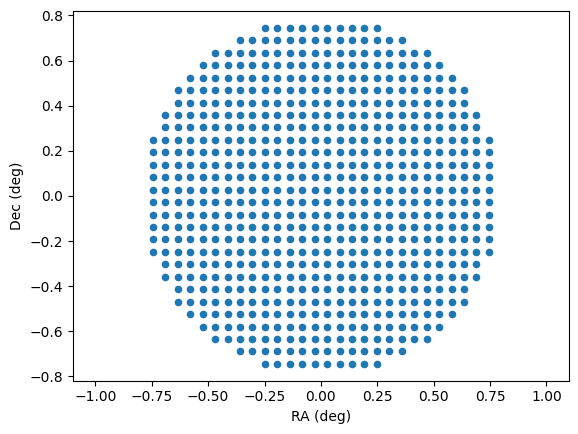

In [ ]:
fp_radius = 0.8 * deg
fp_nrows = 30
fplane = FocalPlane.from_radius(radius=fp_radius, nrows=fp_nrows)
print(f"FocalPlane created with {fplane.n_dets} detectors.")

plt.scatter(np.rad2deg(fplane.x), np.rad2deg(fplane.y), s=20)
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.axis('equal')

2. Simulate a constant elevation scan

In [ ]:
sim_t0 = 1672531200.0       # Example start time (Unix timestamp, e.g., Jan 1, 2023)
sim_az_start = 45.0 * deg   # Scan centered around this azimuth
sim_el = 60.0 * deg         # Elevation of the scan
sim_az_throw = 10.0 * deg   # Width of AZ scan (total sweep)
sim_v_az = 2.0 * deg / s    # Scan speed in Az in deg per sec
sim_srate = 200.0 * Hz      # Sampling rate
sim_duration = 120 * s      # Duration of the observation

Text(0.5, 0, 'Unix Time [s]')

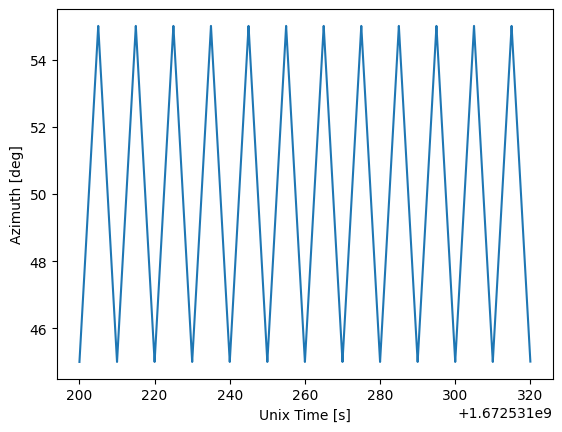

In [ ]:
scan_pattern = generate_ces_scan(
    t0=sim_t0,
    az=sim_az_start,
    el=sim_el,
    az_throw=sim_az_throw,
    v_az=sim_v_az,
    srate=sim_srate,
    duration=sim_duration
)

plt.plot(scan_pattern.t, np.rad2deg(scan_pattern.az))
plt.ylabel("Azimuth [deg]")
plt.xlabel("Unix Time [s]")

3. Build TOD

Example 1: point source

In [ ]:
np.random.seed(42)

tod, _ = build_tod(
    fplane=fplane,
    scan=scan_pattern,
    tod_models=[
        PointSourceSimulator(
            n_srcs=1,
            beam_sigma=4 * arcmin,
            flux_limits=(1e-3, 1)
        ),
    ],
    n_dummy=20,
)

RA bounds: 52.23 to 57.83 deg
Dec bounds: -5.08 to 0.01 deg
Sky map shape: (611, 673), wcs: car:{cdelt:[-0.008333,0.008333],crval:[55.03,0],crpix:[337.21,611.00]}
No sky models provided, initializing TOD with zeros.
Sky map shape: (611, 673), tod shape: (648, 24000)
Simulating 1 point sources within footprint
	Adding point source at RA: 54.07 deg, Dec: -1.76 deg


(4000.0, 4600.0)

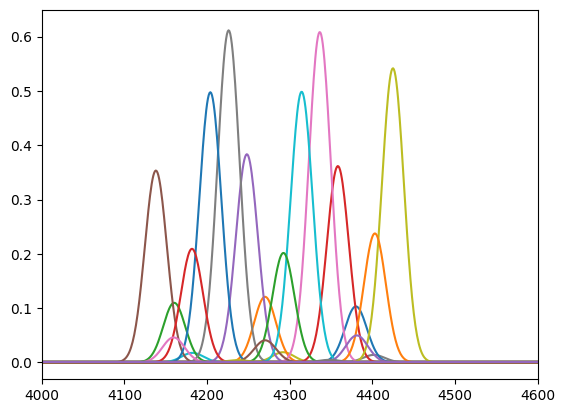

In [ ]:
plt.plot((tod.data)[::10, :].T)
plt.xlim([4000,4600])

Example 2: cosmic rays

In [ ]:
np.random.seed(42)

tod, _ = build_tod(
    fplane=fplane,
    scan=scan_pattern,
    tod_models=[
        CosmicRaySimulator(
            n_per_sample=0.01,
        ),
    ],
)

RA bounds: 52.23 to 57.84 deg
Dec bounds: -5.09 to 0.01 deg
Sky map shape: (612, 673), wcs: car:{cdelt:[-0.008333,0.008333],crval:[55.03,0],crpix:[337.13,611.00]}
No sky models provided, initializing TOD with zeros.
Sky map shape: (612, 673), tod shape: (648, 24000)
Generating 234 cosmic ray hits.


(-1.5273670077323915, 2.0)

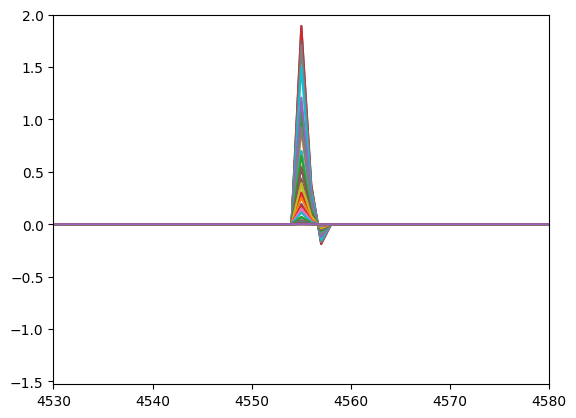

In [ ]:
plt.plot((tod.data)[::10, :].T)
plt.xlim([4530,4580])
plt.ylim(top=2)

Example 3: atmosphere noise

In [ ]:
np.random.seed(42)

nmodes = 1
gains = np.ones((nmodes, fplane.n_dets))
gains[0, :] = np.clip((np.random.randn(fplane.n_dets) * 0.2 + 1), 0, 5)
nlevs = np.ones((nmodes,))

tod, _ = build_tod(
    fplane=fplane,
    scan=scan_pattern,
    tod_models=[
        CorrelatedOOF(
            fknee=100,
            alpha=-2,
            nlevs=nlevs,
            gains=gains,
        ),
        WhiteNoise(
            nlevs=np.ones((fplane.n_dets))*0.2
        ),
    ],
)

RA bounds: 52.23 to 57.84 deg
Dec bounds: -5.09 to 0.01 deg
Sky map shape: (612, 673), wcs: car:{cdelt:[-0.008333,0.008333],crval:[55.03,0],crpix:[337.13,611.00]}
No sky models provided, initializing TOD with zeros.
Sky map shape: (612, 673), tod shape: (648, 24000)


/tmp/ipython-input-7-444831248.py:78: RuntimeWarning: divide by zero encountered in power
  psd = nlev**2 * (1 + (np.abs(f) / fknee)**alpha)


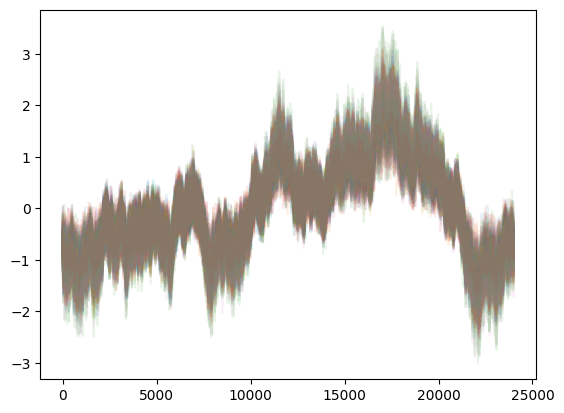

In [ ]:
plt.plot((tod.data)[::10, :].T, alpha=0.1);

Example 4: Combination of everything

In [ ]:
np.random.seed(42)

tod, store = build_tod(
    fplane=fplane,
    scan=scan_pattern,
    tod_models=[
        WhiteNoise(
            nlevs=np.ones((fplane.n_dets))*0.2
        ),
        PointSourceSimulator(
            n_srcs=5,
            beam_sigma=4 * arcmin,
            flux_limits=(1, 3)
        ),
        CosmicRaySimulator(
            n_per_sample=0.01,
            amp_scale=5,
            radius_scale=2 * arcmin,
        ),
    ],
)

RA bounds: 52.23 to 57.84 deg
Dec bounds: -5.09 to 0.01 deg
Sky map shape: (612, 673), wcs: car:{cdelt:[-0.008333,0.008333],crval:[55.03,0],crpix:[337.13,611.00]}
No sky models provided, initializing TOD with zeros.
Sky map shape: (612, 673), tod shape: (648, 24000)
Simulating 5 point sources within footprint
	Adding point source at RA: 52.85 deg, Dec: -0.94 deg
	Adding point source at RA: 56.90 deg, Dec: -4.40 deg
	Adding point source at RA: 56.78 deg, Dec: -3.66 deg
	Adding point source at RA: 55.79 deg, Dec: -3.69 deg
	Adding point source at RA: 55.92 deg, Dec: -3.05 deg
Generating 244 cosmic ray hits.


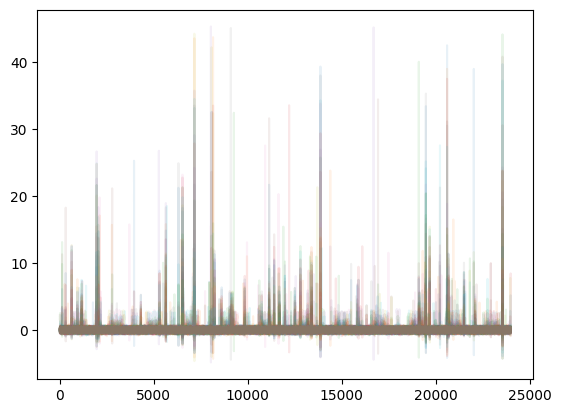

In [ ]:
plt.plot((tod.data)[::10, :].T, alpha=0.1);

In [ ]:
# optionally save it
# np.save("tod.npy", tod.data)

In [ ]:
# do a high pass filtering to get rid of slow signals that are not relevant if atmosphere is present
from scipy.signal import butter, sosfiltfilt

def apply_highpass_filter(data: np.ndarray, srate: float, fc=0.5, order=5) -> np.ndarray:
    """Apply high-pass filter to data"""
    sos = butter(order, fc, btype='highpass', fs=srate, output='sos')
    filtered_data = sosfiltfilt(sos, data, axis=1)
    return filtered_data

apply_highpass_filter = False

if apply_highpass_filter:
    data = apply_highpass_filter(tod.data, srate=sim_srate, fc=1*Hz)
else:
    data = tod.data

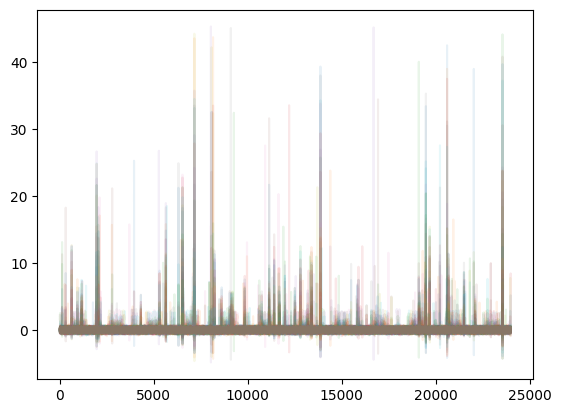

In [ ]:
plt.plot(data[::10, :].T, alpha=0.1);

*Mapping from timeseries to movie*

In [ ]:
import numpy as np
from scipy.sparse import coo_matrix


class FocalPlaneGridBilinear:
    """this works regular spaced detectors on a grid such as in this case, but not
    with actual data which don't fall on a grid"""
    def __init__(self, fplane, pixel_size=0.1*arcmin):
        self.fplane = fplane
        self.pixel_size = pixel_size
        # The create_grid method now returns the 1D coordinate arrays as well for clarity
        self.grid, self.grid_shape, self.grid_coords_1d = self._create_grid()
        self.weight_matrix = self._precompute_weights()
        # You can check if the matrix was created successfully
        print(f"Weight matrix created with {self.weight_matrix.nnz} non-zero elements.")

    def _create_grid(self):
        """Create regular grid covering focal plane"""
        pad = 0.1 * (np.max(self.fplane.x) - np.min(self.fplane.x))
        x_min, x_max = np.min(self.fplane.x) - pad, np.max(self.fplane.x) + pad
        y_min, y_max = np.min(self.fplane.y) - pad, np.max(self.fplane.y) + pad

        nx = int(np.ceil((x_max - x_min) / self.pixel_size))
        ny = int(np.ceil((y_max - y_min) / self.pixel_size))

        grid_x_1d = np.linspace(x_min, x_max, nx)
        grid_y_1d = np.linspace(y_min, y_max, ny)

        # np.meshgrid with 'xy' indexing returns X, Y
        grid_x, grid_y = np.meshgrid(grid_x_1d, grid_y_1d)

        return (grid_x, grid_y), (ny, nx), (grid_x_1d, grid_y_1d)

    def _precompute_weights(self):
        """Precompute bilinear interpolation weights for all grid points"""
        grid_x_1d, grid_y_1d = self.grid_coords_1d
        grid_x_2d, grid_y_2d = self.grid
        detector_points = np.column_stack((self.fplane.x, self.fplane.y))

        rows, cols, weights = [], [], []

        for det_idx, (x_det, y_det) in enumerate(detector_points):
            # Find grid cell containing detector using the correct 1D coordinate arrays
            i = np.searchsorted(grid_x_1d, x_det) - 1
            j = np.searchsorted(grid_y_1d, y_det) - 1

            # Skip if detector outside grid
            if i < 0 or i >= self.grid_shape[1]-1 or j < 0 or j >= self.grid_shape[0]-1:
                continue

            # Get cell corners from the 2D grid arrays
            x0, x1 = grid_x_2d[j, i], grid_x_2d[j, i+1]
            y0, y1 = grid_y_2d[j, i], grid_y_2d[j+1, i]

            # Bilinear weights calculation
            dx = (x_det - x0) / (x1 - x0) if x1 != x0 else 0
            dy = (y_det - y0) / (y1 - y0) if y1 != y0 else 0

            # Corner indices (row-major order)
            idx00 = j * self.grid_shape[1] + i
            idx01 = j * self.grid_shape[1] + i + 1
            idx10 = (j + 1) * self.grid_shape[1] + i
            idx11 = (j + 1) * self.grid_shape[1] + i + 1

            # Weight calculation
            w00 = (1 - dx) * (1 - dy)
            w01 = dx * (1 - dy)
            w10 = (1 - dx) * dy
            w11 = dx * dy

            if np.isnan([w00, w01, w10, w11]).any():
                continue

            # Store weights
            rows.extend([idx00, idx01, idx10, idx11])
            cols.extend([det_idx] * 4)
            weights.extend([w00, w01, w10, w11])

        if not weights:
            print("Warning: No detectors were found within the grid boundaries. The weight matrix will be empty.")

        return coo_matrix((weights, (rows, cols)),
                          shape=(self.grid_shape[0]*self.grid_shape[1],
                                 len(self.fplane.x)))

    def tod_to_video(self, tod_data):
        """Convert TOD data to video using precomputed weights"""
        if tod_data.ndim == 1:
            tod_data = tod_data.reshape(1, -1)
        if tod_data.shape[0] == len(self.fplane.x):
            tod_data = tod_data.T

        if tod_data.shape[1] != len(self.fplane.x):
            raise ValueError("Shape of tod_data does not match number of detectors")

        video_flat = self.weight_matrix.dot(tod_data.T).T
        return video_flat.reshape(-1, self.grid_shape[0], self.grid_shape[1])

import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
from scipy.spatial import Delaunay


class FocalPlaneFlex:
    def __init__(self, fplane, grid_resolution=50):
        self.fplane = fplane
        self.grid_resolution = grid_resolution

        # Create detector coordinate array for triangulation
        self.detector_coords = np.column_stack((self.fplane.x, self.fplane.y))

        # Create triangulation from detector positions
        self.triangulation = Delaunay(self.detector_coords)

        # Create regular output grid and precompute interpolation weights
        self.output_grid, self.grid_shape = self._create_output_grid()
        self.weight_matrix, self.valid_mask = self._precompute_weights()

        print(f"Triangulation created with {len(self.triangulation.simplices)} triangles")
        print(f"Weight matrix created with {self.weight_matrix.nnz} non-zero elements")
        print(f"Valid grid points: {np.sum(self.valid_mask)} / {len(self.valid_mask)}")

    def _create_output_grid(self):
        """Create regular output grid for visualization"""
        # Add padding around detector positions
        pad = 0.1 * (np.max(self.fplane.x) - np.min(self.fplane.x))
        x_min, x_max = np.min(self.fplane.x) - pad, np.max(self.fplane.x) + pad
        y_min, y_max = np.min(self.fplane.y) - pad, np.max(self.fplane.y) + pad

        # Create regular grid for output
        x_grid = np.linspace(x_min, x_max, self.grid_resolution)
        y_grid = np.linspace(y_min, y_max, self.grid_resolution)
        X, Y = np.meshgrid(x_grid, y_grid)

        # Flatten for easier processing
        grid_points = np.column_stack((X.flatten(), Y.flatten()))

        return grid_points, (self.grid_resolution, self.grid_resolution)

    def _precompute_weights(self):
        """Precompute barycentric interpolation weights using Delaunay triangulation"""
        n_grid_points = len(self.output_grid)
        n_detectors = len(self.detector_coords)

        rows, cols, weights = [], [], []
        valid_mask = np.zeros(n_grid_points, dtype=bool)

        # Find which triangle each grid point belongs to
        simplex_indices = self.triangulation.find_simplex(self.output_grid)

        for grid_idx, simplex_idx in enumerate(simplex_indices):
            if simplex_idx == -1:
                # Point is outside convex hull
                continue

            valid_mask[grid_idx] = True

            # Get the vertices of the triangle containing this grid point
            triangle_vertices = self.triangulation.simplices[simplex_idx]

            # Calculate barycentric coordinates
            barycentric_coords = self._calculate_barycentric_coordinates(
                self.output_grid[grid_idx],
                self.detector_coords[triangle_vertices]
            )

            # Store weights for each vertex of the triangle
            for i, vertex_idx in enumerate(triangle_vertices):
                weight = barycentric_coords[i]
                if weight > 1e-10:  # Only store significant weights
                    rows.append(grid_idx)
                    cols.append(vertex_idx)
                    weights.append(weight)

        weight_matrix = coo_matrix(
            (weights, (rows, cols)),
            shape=(n_grid_points, n_detectors)
        )

        return weight_matrix, valid_mask

    def _calculate_barycentric_coordinates(self, point, triangle_vertices):
        """Calculate barycentric coordinates of a point within a triangle"""
        # Triangle vertices
        A, B, C = triangle_vertices

        # Vectors
        v0 = C - A
        v1 = B - A
        v2 = point - A

        # Compute dot products
        dot00 = np.dot(v0, v0)
        dot01 = np.dot(v0, v1)
        dot02 = np.dot(v0, v2)
        dot11 = np.dot(v1, v1)
        dot12 = np.dot(v1, v2)

        # Compute barycentric coordinates
        inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
        u = (dot11 * dot02 - dot01 * dot12) * inv_denom
        v = (dot00 * dot12 - dot01 * dot02) * inv_denom
        w = 1 - u - v

        return np.array([w, v, u])  # Corresponds to vertices A, B, C

    def tod_to_video(self, tod_data):
        """Convert TOD data to video using precomputed triangulation weights"""
        if tod_data.ndim == 1:
            tod_data = tod_data.reshape(1, -1)
        if tod_data.shape[0] == len(self.fplane.x):
            tod_data = tod_data.T

        if tod_data.shape[1] != len(self.fplane.x):
            raise ValueError(f"Shape of tod_data {tod_data.shape} does not match number of detectors {len(self.fplane.x)}")

        # Interpolate data to grid points
        video_flat = self.weight_matrix.dot(tod_data.T).T

        # Set invalid (extrapolated) points to zero
        video_flat[:, ~self.valid_mask] = 0

        # Reshape to video format
        n_frames = video_flat.shape[0]
        video = video_flat.reshape(n_frames, self.grid_shape[0], self.grid_shape[1])

        return video

    def get_detector_triangulation_info(self):
        """Return information about the triangulation for debugging/visualization"""
        return {
            'triangles': self.triangulation.simplices,
            'detector_coords': self.detector_coords,
            'n_triangles': len(self.triangulation.simplices),
            'convex_hull': self.triangulation.convex_hull
        }

    def plot_triangulation(self):
        """Plot the triangulation for visualization (requires matplotlib)"""
        try:
            import matplotlib.pyplot as plt

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

            # Plot triangulation
            ax1.triplot(self.detector_coords[:, 0], self.detector_coords[:, 1],
                       self.triangulation.simplices, 'k-', alpha=0.3)
            ax1.plot(self.detector_coords[:, 0], self.detector_coords[:, 1], 'ro', markersize=3)
            ax1.set_title('Delaunay Triangulation of Detectors')
            ax1.set_xlabel('X coordinate')
            ax1.set_ylabel('Y coordinate')
            ax1.grid(True, alpha=0.3)

            # Plot output grid with valid points highlightedc
            grid_2d = self.output_grid.reshape(self.grid_shape[0], self.grid_shape[1], 2)
            valid_2d = self.valid_mask.reshape(self.grid_shape[0], self.grid_shape[1])

            ax2.contourf(grid_2d[:, :, 0], grid_2d[:, :, 1], valid_2d.astype(int),
                        levels=[0, 0.5, 1], colors=['lightgray', 'lightblue'], alpha=0.7)
            ax2.plot(self.detector_coords[:, 0], self.detector_coords[:, 1], 'ro', markersize=3)
            ax2.set_title('Output Grid (Blue=Valid, Gray=Extrapolated)')
            ax2.set_xlabel('X coordinate')
            ax2.set_ylabel('Y coordinate')
            ax2.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

        except ImportError:
            print("Matplotlib not available for plotting")


In [ ]:
# fp_grid = FocalPlaneGrid(tod.fplane, pixel_size=4*arcmin)
fp_grid = FocalPlaneFlex(tod.fplane, grid_resolution=32)

Triangulation created with 1236 triangles
Weight matrix created with 1689 non-zero elements
Valid grid points: 568 / 1024


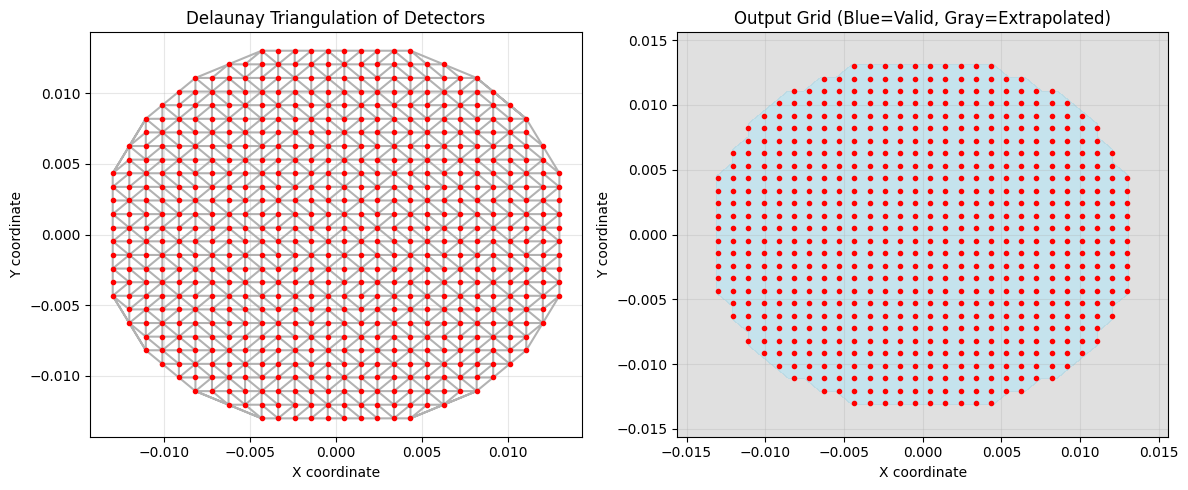

In [ ]:
fp_grid.plot_triangulation()

In [ ]:
import numpy as np
from scipy.sparse import coo_matrix


# class FocalPlaneGridBilinear:
#     """this works regular spaced detectors on a grid such as in this case, but not
#     with actual data which don't fall on a grid"""
#     def __init__(self, fplane, pixel_size=0.1*arcmin):
#         self.fplane = fplane
#         self.pixel_size = pixel_size
#         # The create_grid method now returns the 1D coordinate arrays as well for clarity
#         self.grid, self.grid_shape, self.grid_coords_1d = self._create_grid()
#         self.weight_matrix = self._precompute_weights()
#         # You can check if the matrix was created successfully
#         print(f"Weight matrix created with {self.weight_matrix.nnz} non-zero elements.")

#     def _create_grid(self):
#         """Create regular grid covering focal plane"""
#         pad = 0.1 * (np.max(self.fplane.x) - np.min(self.fplane.x))
#         x_min, x_max = np.min(self.fplane.x) - pad, np.max(self.fplane.x) + pad
#         y_min, y_max = np.min(self.fplane.y) - pad, np.max(self.fplane.y) + pad

#         nx = int(np.ceil((x_max - x_min) / self.pixel_size))
#         ny = int(np.ceil((y_max - y_min) / self.pixel_size))

#         grid_x_1d = np.linspace(x_min, x_max, nx)
#         grid_y_1d = np.linspace(y_min, y_max, ny)

#         # np.meshgrid with 'xy' indexing returns X, Y
#         grid_x, grid_y = np.meshgrid(grid_x_1d, grid_y_1d)

#         return (grid_x, grid_y), (ny, nx), (grid_x_1d, grid_y_1d)

#     def _precompute_weights(self):
#         """Precompute bilinear interpolation weights for all grid points"""
#         grid_x_1d, grid_y_1d = self.grid_coords_1d
#         grid_x_2d, grid_y_2d = self.grid
#         detector_points = np.column_stack((self.fplane.x, self.fplane.y))

#         rows, cols, weights = [], [], []

#         for det_idx, (x_det, y_det) in enumerate(detector_points):
#             # Find grid cell containing detector using the correct 1D coordinate arrays
#             i = np.searchsorted(grid_x_1d, x_det) - 1
#             j = np.searchsorted(grid_y_1d, y_det) - 1

#             # Skip if detector outside grid
#             if i < 0 or i >= self.grid_shape[1]-1 or j < 0 or j >= self.grid_shape[0]-1:
#                 continue

#             # Get cell corners from the 2D grid arrays
#             x0, x1 = grid_x_2d[j, i], grid_x_2d[j, i+1]
#             y0, y1 = grid_y_2d[j, i], grid_y_2d[j+1, i]

#             # Bilinear weights calculation
#             dx = (x_det - x0) / (x1 - x0) if x1 != x0 else 0
#             dy = (y_det - y0) / (y1 - y0) if y1 != y0 else 0

#             # Corner indices (row-major order)
#             idx00 = j * self.grid_shape[1] + i
#             idx01 = j * self.grid_shape[1] + i + 1
#             idx10 = (j + 1) * self.grid_shape[1] + i
#             idx11 = (j + 1) * self.grid_shape[1] + i + 1

#             # Weight calculation
#             w00 = (1 - dx) * (1 - dy)
#             w01 = dx * (1 - dy)
#             w10 = (1 - dx) * dy
#             w11 = dx * dy

#             if np.isnan([w00, w01, w10, w11]).any():
#                 continue

#             # Store weights
#             rows.extend([idx00, idx01, idx10, idx11])
#             cols.extend([det_idx] * 4)
#             weights.extend([w00, w01, w10, w11])

#         if not weights:
#             print("Warning: No detectors were found within the grid boundaries. The weight matrix will be empty.")

#         return coo_matrix((weights, (rows, cols)),
#                           shape=(self.grid_shape[0]*self.grid_shape[1],
#                                  len(self.fplane.x)))

#     def tod_to_video(self, tod_data):
#         """Convert TOD data to video using precomputed weights"""
#         if tod_data.ndim == 1:
#             tod_data = tod_data.reshape(1, -1)
#         if tod_data.shape[0] == len(self.fplane.x):
#             tod_data = tod_data.T

#         if tod_data.shape[1] != len(self.fplane.x):
#             raise ValueError("Shape of tod_data does not match number of detectors")

#         video_flat = self.weight_matrix.dot(tod_data.T).T
#         return video_flat.reshape(-1, self.grid_shape[0], self.grid_shape[1])

import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
from scipy.spatial import Delaunay
from scipy.interpolate import RegularGridInterpolator

class FocalPlaneFlex:
    def __init__(self, fplane, grid_resolution=50):
        self.fplane = fplane
        self.grid_resolution = grid_resolution

        # Create detector coordinate array for triangulation
        self.detector_coords = np.column_stack((self.fplane.x, self.fplane.y))

        # Create triangulation from detector positions
        self.triangulation = Delaunay(self.detector_coords)

        # Create regular output grid and precompute interpolation weights
        self.output_grid, self.x_grid, self.y_grid, self.grid_shape = self._create_output_grid()
        self.weight_matrix, self.valid_mask = self._precompute_weights()

        print(f"Triangulation created with {len(self.triangulation.simplices)} triangles")
        print(f"Weight matrix created with {self.weight_matrix.nnz} non-zero elements")
        print(f"Valid grid points: {np.sum(self.valid_mask)} / {len(self.valid_mask)}")

    def _create_output_grid(self):
        """Create regular output grid for visualization"""
        pad = 0.1 * (np.max(self.fplane.x) - np.min(self.fplane.x))
        x_min, x_max = np.min(self.fplane.x) - pad, np.max(self.fplane.x) + pad
        y_min, y_max = np.min(self.fplane.y) - pad, np.max(self.fplane.y) + pad

        # Create regular grid for output
        x_grid = np.linspace(x_min, x_max, self.grid_resolution)
        y_grid = np.linspace(y_min, y_max, self.grid_resolution)
        X, Y = np.meshgrid(x_grid, y_grid)

        grid_points = np.column_stack((X.flatten(), Y.flatten()))

        # Return the grid axes as well
        return grid_points, x_grid, y_grid, (self.grid_resolution, self.grid_resolution)


    def _precompute_weights(self):
        """Precompute barycentric interpolation weights using Delaunay triangulation"""
        n_grid_points = len(self.output_grid)
        n_detectors = len(self.detector_coords)

        rows, cols, weights = [], [], []
        valid_mask = np.zeros(n_grid_points, dtype=bool)

        # Find which triangle each grid point belongs to
        simplex_indices = self.triangulation.find_simplex(self.output_grid)

        for grid_idx, simplex_idx in enumerate(simplex_indices):
            if simplex_idx == -1:
                # Point is outside convex hull
                continue

            valid_mask[grid_idx] = True

            # Get the vertices of the triangle containing this grid point
            triangle_vertices = self.triangulation.simplices[simplex_idx]

            # Calculate barycentric coordinates
            barycentric_coords = self._calculate_barycentric_coordinates(
                self.output_grid[grid_idx],
                self.detector_coords[triangle_vertices]
            )

            # Store weights for each vertex of the triangle
            for i, vertex_idx in enumerate(triangle_vertices):
                weight = barycentric_coords[i]
                if weight > 1e-10:  # Only store significant weights
                    rows.append(grid_idx)
                    cols.append(vertex_idx)
                    weights.append(weight)

        weight_matrix = coo_matrix(
            (weights, (rows, cols)),
            shape=(n_grid_points, n_detectors)
        )

        return weight_matrix, valid_mask

    def _calculate_barycentric_coordinates(self, point, triangle_vertices):
        """Calculate barycentric coordinates of a point within a triangle"""
        # Triangle vertices
        A, B, C = triangle_vertices

        # Vectors
        v0 = C - A
        v1 = B - A
        v2 = point - A

        # Compute dot products
        dot00 = np.dot(v0, v0)
        dot01 = np.dot(v0, v1)
        dot02 = np.dot(v0, v2)
        dot11 = np.dot(v1, v1)
        dot12 = np.dot(v1, v2)

        # Compute barycentric coordinates
        inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
        u = (dot11 * dot02 - dot01 * dot12) * inv_denom
        v = (dot00 * dot12 - dot01 * dot02) * inv_denom
        w = 1 - u - v

        return np.array([w, v, u])  # Corresponds to vertices A, B, C

    def tod_to_video(self, tod_data):
        """Convert TOD data to video using precomputed triangulation weights"""
        if tod_data.ndim == 1:
            tod_data = tod_data.reshape(1, -1)
        if tod_data.shape[0] == len(self.fplane.x):
            tod_data = tod_data.T

        if tod_data.shape[1] != len(self.fplane.x):
            raise ValueError(f"Shape of tod_data {tod_data.shape} does not match number of detectors {len(self.fplane.x)}")

        # Interpolate data to grid points
        video_flat = self.weight_matrix.dot(tod_data.T).T

        # Set invalid (extrapolated) points to zero
        video_flat[:, ~self.valid_mask] = 0

        # Reshape to video format
        n_frames = video_flat.shape[0]
        video = video_flat.reshape(n_frames, self.grid_shape[0], self.grid_shape[1])

        return video

    def video_to_tod(self, video_data):
        """
        Maps image or video data back to the original detector positions.
        This is the reverse operation of tod_to_video.

        Args:
            video_data (np.ndarray): A single image (H, W) or a sequence of
                                    images (n_frames, H, W). The dimensions
                                    H and W must match self.grid_resolution.

        Returns:
            np.ndarray: The resampled detector data (TOD) with shape
                        (n_frames, n_detectors).
        """
        if video_data.ndim == 2:
            video_data = video_data[np.newaxis, :, :]

        n_frames, h, w = video_data.shape
        if (h, w) != self.grid_shape:
            raise ValueError(
                f"Input video shape {(h, w)} does not match grid shape {self.grid_shape}"
            )

        query_points = self.detector_coords
        n_detectors = len(query_points)

        tod_data = np.zeros((n_frames, n_detectors))

        for i in range(n_frames):
            frame = video_data[i]

            interpolator = RegularGridInterpolator(
                (self.y_grid, self.x_grid),
                frame,
                method='linear',
                bounds_error=False,
                fill_value=0
            )
            tod_data[i, :] = interpolator(query_points[:, ::-1])

        if tod_data.shape[0] == 1:
            return tod_data.flatten()

        return tod_data

    def get_detector_triangulation_info(self):
        """Return information about the triangulation for debugging/visualization"""
        return {
            'triangles': self.triangulation.simplices,
            'detector_coords': self.detector_coords,
            'n_triangles': len(self.triangulation.simplices),
            'convex_hull': self.triangulation.convex_hull
        }

    def plot_triangulation(self):
        """Plot the triangulation for visualization (requires matplotlib)"""
        try:
            import matplotlib.pyplot as plt

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

            # Plot triangulation
            ax1.triplot(self.detector_coords[:, 0], self.detector_coords[:, 1],
                       self.triangulation.simplices, 'k-', alpha=0.3)
            ax1.plot(self.detector_coords[:, 0], self.detector_coords[:, 1], 'ro', markersize=3)
            ax1.set_title('Delaunay Triangulation of Detectors')
            ax1.set_xlabel('X coordinate')
            ax1.set_ylabel('Y coordinate')
            ax1.grid(True, alpha=0.3)

            # Plot output grid with valid points highlightedc
            grid_2d = self.output_grid.reshape(self.grid_shape[0], self.grid_shape[1], 2)
            valid_2d = self.valid_mask.reshape(self.grid_shape[0], self.grid_shape[1])

            ax2.contourf(grid_2d[:, :, 0], grid_2d[:, :, 1], valid_2d.astype(int),
                        levels=[0, 0.5, 1], colors=['lightgray', 'lightblue'], alpha=0.7)
            ax2.plot(self.detector_coords[:, 0], self.detector_coords[:, 1], 'ro', markersize=3)
            ax2.set_title('Output Grid (Blue=Valid, Gray=Extrapolated)')
            ax2.set_xlabel('X coordinate')
            ax2.set_ylabel('Y coordinate')
            ax2.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

        except ImportError:
            print("Matplotlib not available for plotting")


In [ ]:
fp_grid = FocalPlaneFlex(tod.fplane, grid_resolution=32)

Triangulation created with 1236 triangles
Weight matrix created with 1689 non-zero elements
Valid grid points: 568 / 1024


In [ ]:
# video = fp_grid.tod_to_video(data)
video = fp_grid.tod_to_video(data)
print(video.shape)

(24000, 32, 32)


Turning video into a series of long exposure image

In [ ]:
chunk_size = int(1 * sim_srate)  # 1 second, can be changed
images = np.array([np.sum(video[i:i+chunk_size], axis=0) for i in range(0, len(video), chunk_size)])

Visualize

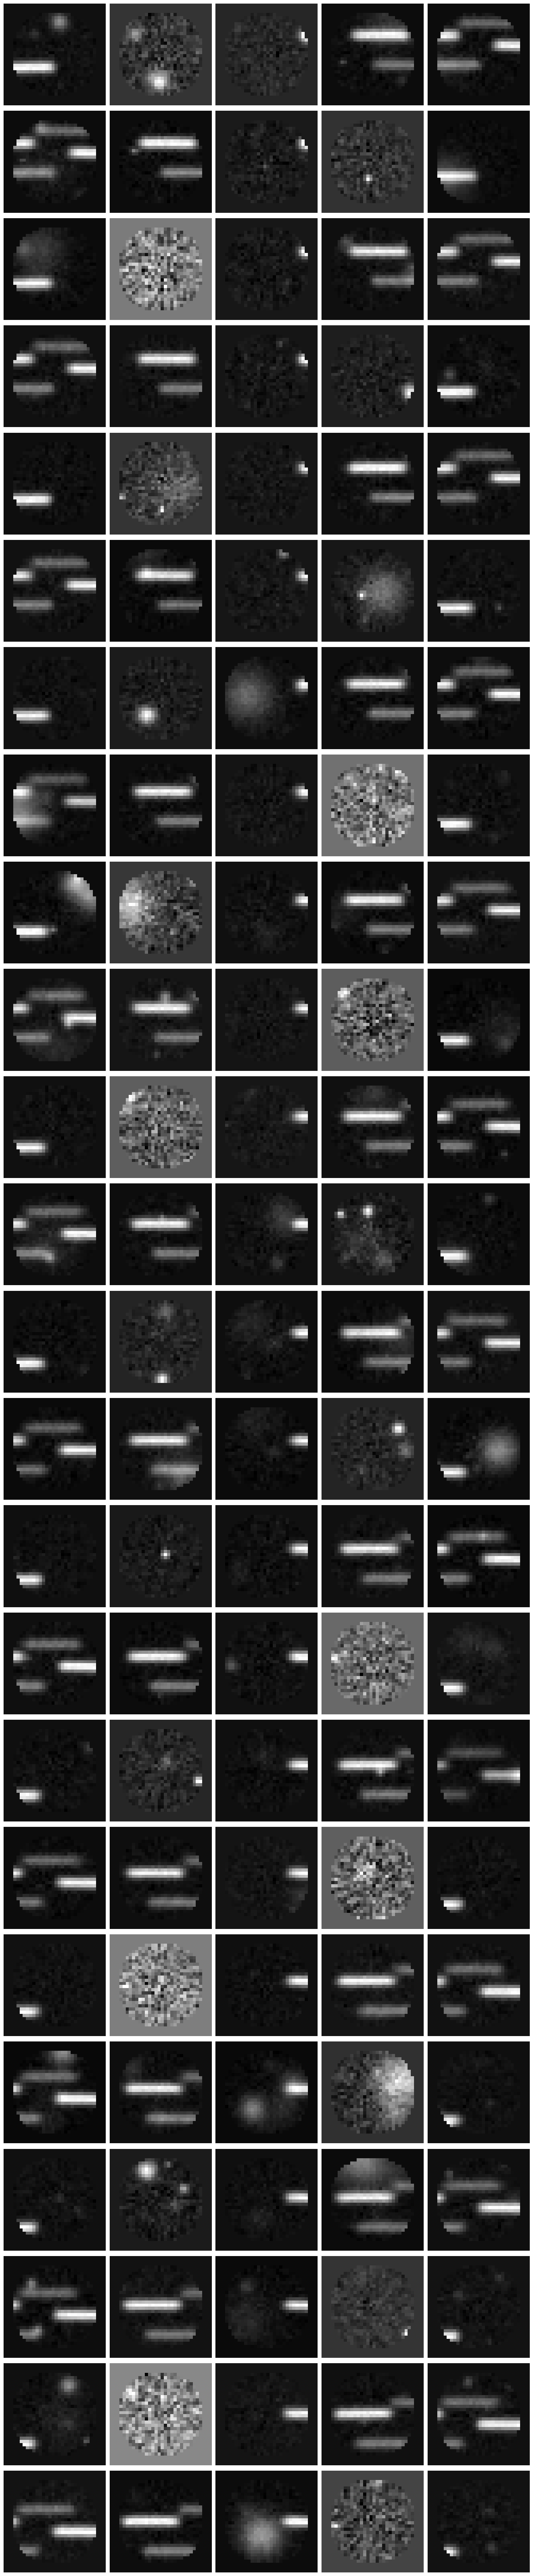

In [ ]:
# Calculate grid dimensions
n_images = len(images)
n_cols = 5
n_rows = (n_images + n_cols - 1) // n_cols  # Ceiling division

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3*n_rows))

# Handle case where there's only one row
if n_rows == 1:
    axes = axes.reshape(1, -1)

# Plot images
for i, im in enumerate(images):
    row = i // n_cols
    col = i % n_cols

    axes[row, col].imshow(im, cmap='gray')
    axes[row, col].axis('off')

# Hide any unused subplots
for i in range(n_images, n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].axis('off')
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()

## Produce Labels

In [ ]:
# masks of different objects are stored in `store`.
# They can be turned into images like the actual data
# First we turn them into video and then chunking into
# aggregated images like done before
video_labels_cr = fp_grid.tod_to_video(store['tod_cr_mask'])
image_labels_cr = np.array([np.sum(video_labels_cr[i:i+chunk_size], axis=0) for i in range(0, len(video_labels_cr), chunk_size)])
video_labels_ptsrc = fp_grid.tod_to_video(store['tod_ptsrc_mask'])
image_labels_ptsrc = np.array([np.sum(video_labels_ptsrc[i:i+chunk_size], axis=0) for i in range(0, len(video_labels_ptsrc), chunk_size)])
image_labels = (image_labels_cr > 0) + (image_labels_ptsrc > 0)*2    # 0: background, 1: cr, 2: ptsrc, 3: cr + ptsrc

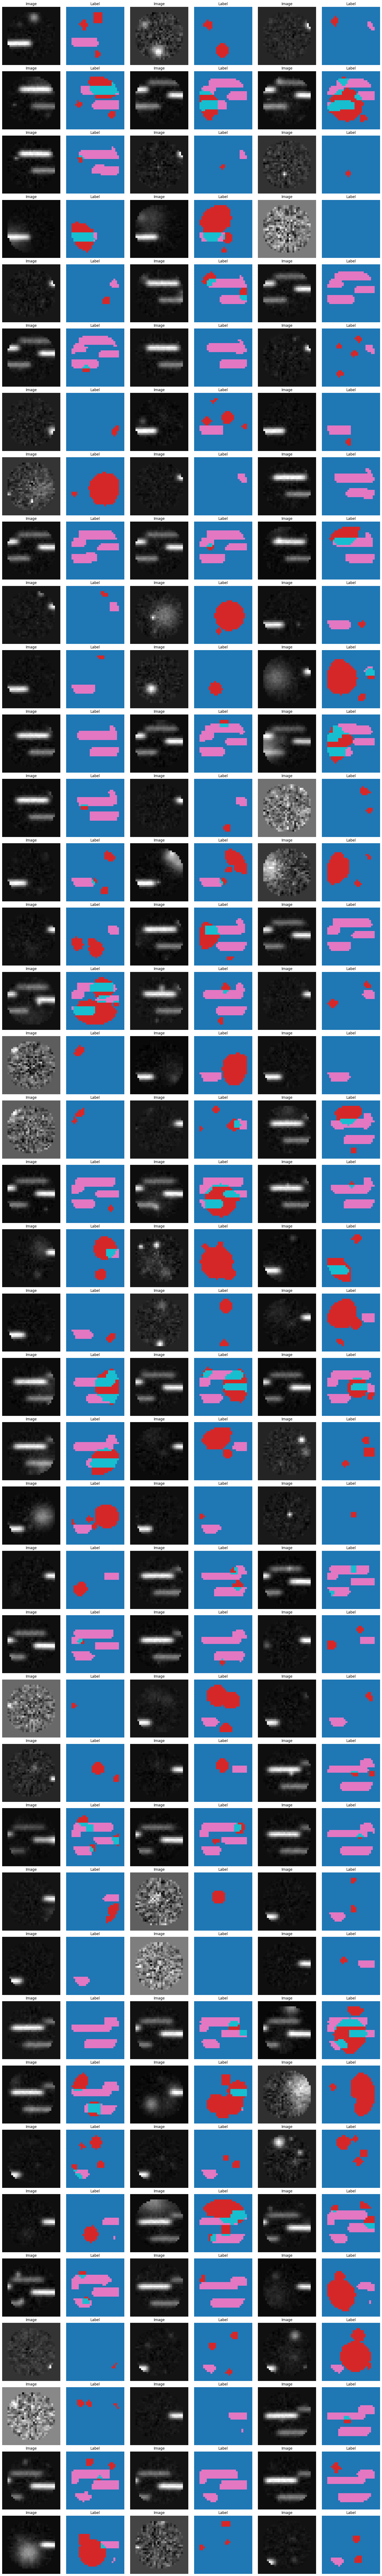

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate number of rows needed for 3 columns
n_images = len(images)
n_cols = 3
n_rows = int(np.ceil(n_images / n_cols))

# Create the figure with subplots
fig, axes = plt.subplots(n_rows, n_cols * 2, figsize=(18, 3*n_rows))

# Handle case where you have only one row
if n_rows == 1:
    axes = axes.reshape(1, -1)

for idx, (im, im_label) in enumerate(zip(images, image_labels)):
    row = idx // n_cols
    col = idx % n_cols

    # Each image pair takes 2 subplot positions (original + label)
    img_col = col * 2
    label_col = col * 2 + 1

    # Display original image
    axes[row, img_col].imshow(im, cmap='gray')
    axes[row, img_col].set_title('Image')
    axes[row, img_col].axis('off')

    # Display label image
    axes[row, label_col].imshow(im_label, cmap='tab10', vmin=0, vmax=3)
    axes[row, label_col].set_title('Label')
    axes[row, label_col].axis('off')

# Hide any unused subplots
for idx in range(n_images, n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    img_col = col * 2
    label_col = col * 2 + 1
    axes[row, img_col].axis('off')
    axes[row, label_col].axis('off')

plt.tight_layout(pad=0.5, h_pad=0.5, w_pad=0.5)
plt.show()

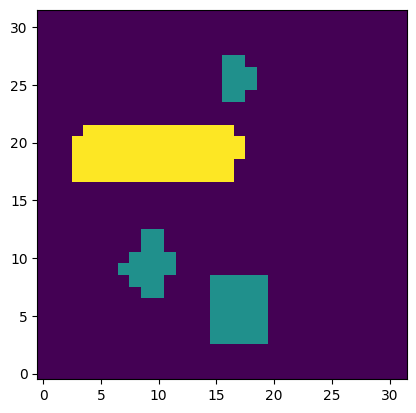

In [ ]:
plt.imshow(image_labels[0], origin="lower")

In [ ]:
det_mask_interp = fp_grid.video_to_tod(image_labels[0])

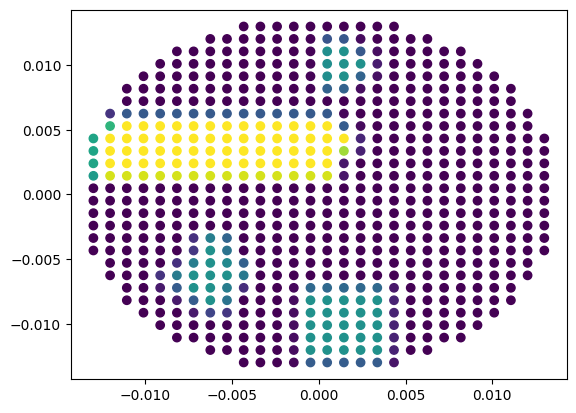

In [ ]:
plt.scatter(fplane.x, fplane.y, c=det_mask_interp)